### Initialization

##### Installation

In [1]:
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Imports

In [2]:
# system imports
import os
import cv2
import uuid
import json
import joblib
from typing import Any

# utility imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# third-party imports
from rembg import remove

# ML imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

#FileUpload
from ipywidgets import FileUpload


##### Global vars

In [10]:
uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)

filename = None
extension = None
dir_identifier = None

def on_upload_change(change):
    global filename
    global extension
    global dir_identifier
    if uploader.value:
        upload_info = uploader.value[0]
        filename = upload_info['name']
        content = upload_info['content']

        os.makedirs("assets", exist_ok=True)
        with open(f"assets/{filename}", "wb") as f:
            f.write(content)

        print(f"Arquivo salvo em assets/{filename}")

        if not os.path.exists(f'assets/{filename}'):
            raise FileNotFoundError(f"File '{filename}' does not exist.")

        dir_identifier = uuid.uuid4().hex
        extension = filename.split('.')[-1]
        filename = '.'.join(filename.split('.')[:-1])

        os.makedirs(f'outputs/{dir_identifier}', exist_ok=True)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

##### Generate dataset (from a LabelStudio annotation)

##### Train, save and load kNN model

##### Plot function (to compare and save two images)

In [11]:
def plot_images(
    step: str,
    original: np.ndarray,
    processed: np.ndarray,
    title1: str = 'Original',
    title2: str = 'Processed'
) -> None:
    """
    Plots two images side by side for comparison.

    Args:
        step (str): Step identifier for the image.
        original (np.ndarray): The original image to be displayed.
        processed (np.ndarray): The processed image to be displayed.
        title1 (str, optional): Title for the original image. Defaults to 'Original'.
        title2 (str, optional): Title for the processed image. Defaults to 'Processed'.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.tight_layout()
    
    cv2.imwrite(f'outputs/{dir_identifier}/{filename}-{step}.{extension}', processed)
    plt.savefig(f'outputs/{dir_identifier}/plot-{filename}-{step}.{extension}')
    plt.show()

### Remove background of pH strip

##### Remove background

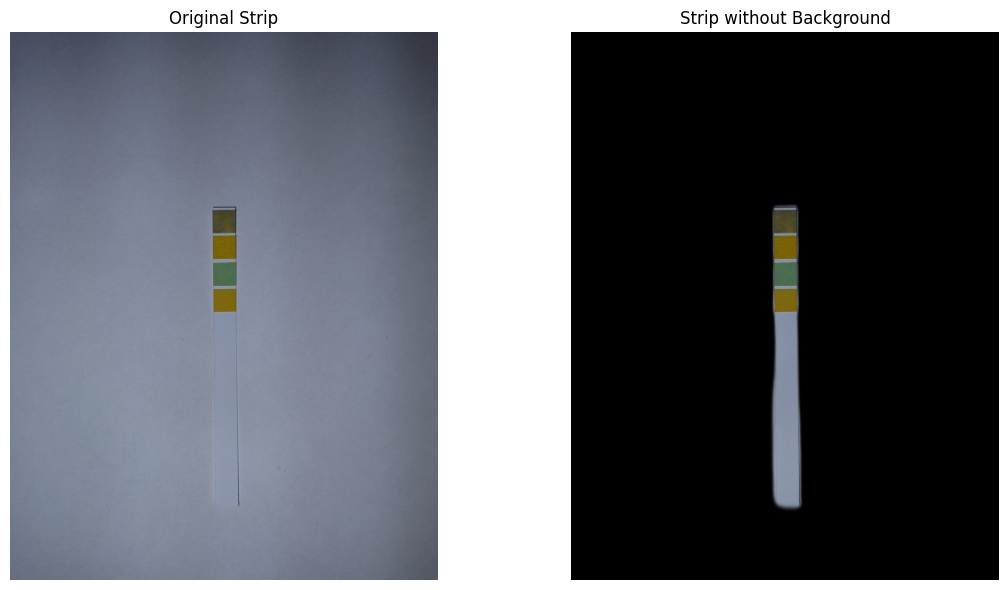

In [12]:
def remove_background(
  strip: np.ndarray,
) -> np.ndarray:
    """
    Removes the background from the strip image using rembg.

    Args:
        strip (np.ndarray): The input image with a background.

    Returns:
        np.ndarray: The image with the background removed.
    """
    strip_without_bg = remove(strip)
    
    plot_images(
        step='1-remove-bg',
        original=strip,
        processed=strip_without_bg,
        title1='Original Strip',
        title2='Strip without Background'
    )
    return strip_without_bg

strip = cv2.imread(f'assets/{filename}.{extension}')
strip_without_bg = remove_background(strip)

### Adjust strip

##### Rotate strip

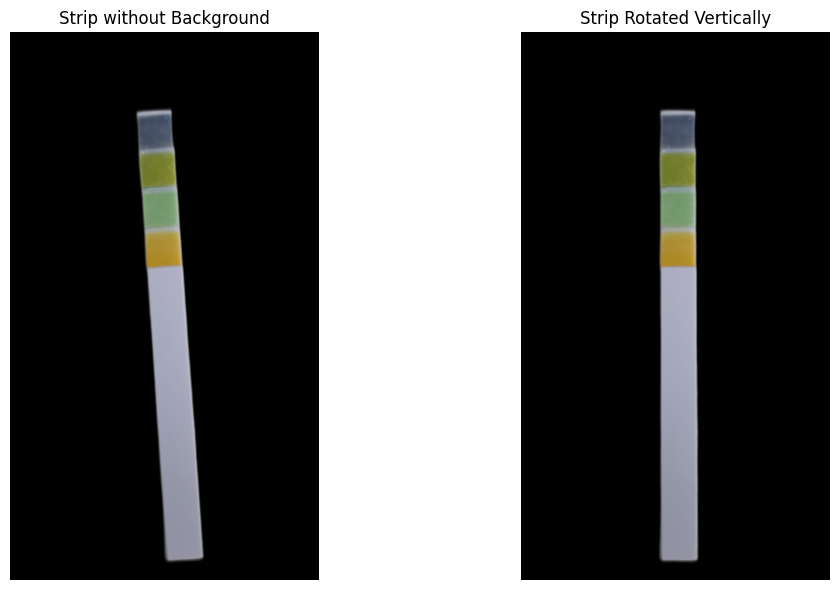

In [12]:
def rotate_vertically(strip: np.ndarray) -> np.ndarray:
    """
    Aligns the strip vertically by detecting its orientation.

    Args:
        strip (np.ndarray): Input image of the strip.

    Returns:
        np.ndarray: The rotated image of the strip aligned vertically.
    """
    gray = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("Nenhum contorno encontrado.")

    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]
    width, height = rect[1]

    if width > height:
        corrected_angle = angle - 90
    else:
        corrected_angle = angle

    if corrected_angle < -45:
        corrected_angle += 90

    (h, w) = strip.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, corrected_angle, 1.0)

    rotated = cv2.warpAffine(
        strip,
        M,
        (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)
    )

    gray_rotated = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    _, binary_rotated = cv2.threshold(gray_rotated, 10, 255, cv2.THRESH_BINARY)
    top_half = binary_rotated[:h // 2, :]
    bottom_half = binary_rotated[h // 2:, :]

    top_mass = cv2.countNonZero(top_half)
    bottom_mass = cv2.countNonZero(bottom_half)

    if top_mass > bottom_mass:
        rotated = cv2.flip(rotated, 0)

    plot_images(
        step='2-rotate-vertically',
        original=strip,
        processed=rotated,
        title1='Strip without Background',
        title2='Strip Rotated Vertically'
    )

    return rotated



rotated_strip = rotate_vertically(strip_without_bg)


##### Crop strip

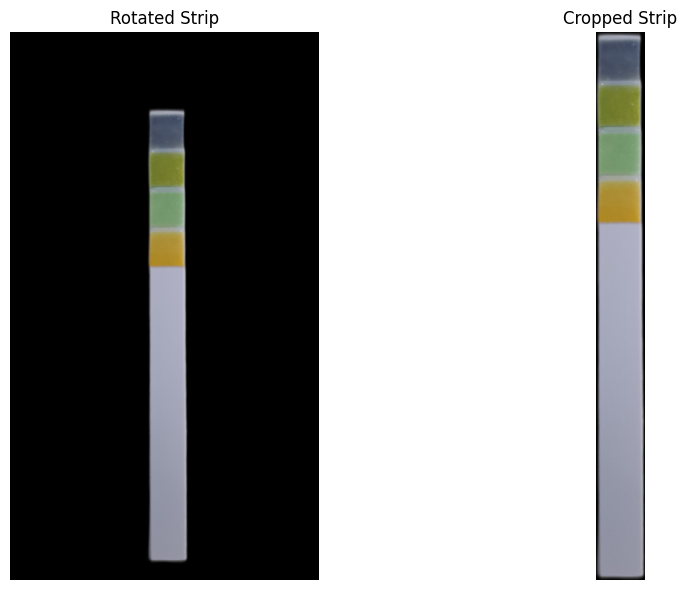

In [13]:
def crop(    
    strip: np.ndarray,
) -> np.ndarray:
    """
    Crops the strip strip to remove any excess background.

    Args:
        strip (np.ndarray): The strip image of the strip.

    Returns:
        np.ndarray: The cropped image of the strip.
    """
    gray_strip = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    _, binary_strip = cv2.threshold(gray_strip, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_strip, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped = strip[y:y+h, x:x+w]

    plot_images(
        step='3-crop',
        original=strip,
        processed=cropped,
        title1='Rotated Strip',
        title2='Cropped Strip'
    )

    return cropped
  
cropped_strip = crop(rotated_strip)